### Libraries

In [4]:
import os
import numpy as np
import nibabel as nb
import pandas as pd
import glob
import matplotlib.pyplot as plt
from enigmatoolbox.plotting import plot_cortical
from enigmatoolbox.utils.parcellation import parcel_to_surface
from enigmatoolbox.utils.parcellation import surface_to_parcel
from enigmatoolbox.datasets import load_sc, load_fc
from nilearn import plotting
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.mesh.array_operations import smooth_array
from brainstat.datasets import fetch_mask
from brainstat.stats.terms import FixedEffect
from brainstat.datasets import fetch_yeo_networks_metadata
from brainstat.stats.SLM import SLM
from brainspace.datasets import load_mask
from brainspace.utils.parcellation import map_to_labels
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import cmocean
from math import pi

### Load surfaces and masks

In [6]:
# Set dataset PNI as working directory
os.chdir('/data_/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0')

# Path to MICAPIPE surf = mask_5k !
micapipe=os.popen("echo $MICAPIPE").read()[:-1]

# Load fsLR 32k
f32k_lh = read_surface(micapipe + '/surfaces/fsLR-32k.L.surf.gii', itype='gii')
f32k_rh = read_surface(micapipe + '/surfaces/fsLR-32k.R.surf.gii', itype='gii')

# Load native mid surface
inf_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
inf_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')

mask_lh =  nb.load(micapipe + '/surfaces/fsLR-5k.R.mask.shape.gii').darrays[0].data
mask_rh =  nb.load(micapipe + '/surfaces/fsLR-5k.L.mask.shape.gii').darrays[0].data
mask_5k = np.concatenate((mask_lh, mask_rh), axis=0)
# Labels and boolean mask
mask_surf = mask_5k != 0

f5k_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.surf.gii', itype='gii')
f5k_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.surf.gii', itype='gii')

# Load fsLR masks
mask_32k = load_mask(join=True)

# Load fsaverage5
fs5_lh = read_surface(micapipe+'/surfaces/fsaverage5/surf/lh.pial', itype='fs')
fs5_rh = read_surface(micapipe+'/surfaces/fsaverage5/surf/rh.pial', itype='fs')
fs5_mask = fetch_mask("fsaverage5")

# Load fsaverage5 inflated surfaces and mask
#fs5_lh = read_surface(micapipe+'/surfaces/fsaverage5/surf/lh.inflated', itype='fs')
#fs5_rh = read_surface(micapipe+'/surfaces/fsaverage5/surf/rh.inflated', itype='fs')
#fs5_mask = fetch_mask("fsaverage5")

# Read label for conte69
micapipe='/data_/mica1/01_programs/micapipe-v0.2.0'
#labels_c69 = np.loadtxt(open(micapipe + '/parcellations/' + atlas + '_conte69.csv'), dtype=int)

In [7]:
# Smooth intencities
def smooth_surf(surf_l, surf_r, points, Mask, Kernel='uniform', Niter=3, Relax=0.35):
    '''
    This function smooth an array (left and right) on a given surface
    Parameters
    ----------
    surf_l : np.array left surface 
    surf_r : np.array right surface
    points : np.array surface data
    Kernel : {'uniform', 'gaussian', 'inverse_distance'}
    Niter  : int, optional Number of smooth iterations
    Relax  : relax : float, optional relaxation factor
    Mask   : str or 1D ndarray, optional
    Returns
    -------
    sdata : smoothed numpy array
    
    '''
    Ndim = Mask.shape[0] 
    n2dim = int(Ndim/2)
    Mask_l=Mask[0:n2dim]
    Mask_r=Mask[n2dim:Ndim]
    sdata = np.concatenate((smooth_array(surf_l, points[0:n2dim],kernel=Kernel, n_iter=Niter,relax=Relax, mask=Mask_l), 
                          smooth_array(surf_r, points[n2dim:Ndim],kernel=Kernel, n_iter=Niter,relax=Relax, mask=Mask_r)), axis=0)
    return(sdata)

## Load cortico-cortical functional connectivity data

In [8]:
# Load CSV file containing subject and session information
csv_dir = '/data/mica1/03_projects/youngeun/lists'
csv_file = f"10PNC_T1map.csv"
subject_session_info = pd.read_csv(csv_dir + '/' + csv_file, header=None, names=['info'], delimiter=',')

# Extract subject and session information from each row
files = []
for index, row in subject_session_info.iterrows():
    info = row['info'].split(',')
    subject = index[4:]  # Extract subject ID
    session = info[0][4:].strip()  # Extract session ID
    files_fc = f"sub-{subject}/ses-03/func/desc-me_task-rest_bold/surf/*_surf-fsLR-32k_atlas-schaefer-400_desc-FC.shape.gii"
    files.extend(glob.glob(files_fc))

# Load intensity profiles from each file
profiles = []
for file_path in files:
    profile_data = nb.load(file_path).darrays[0].data
    profiles.append(profile_data)
profiles = np.array(profiles)
fc = np.mean(profiles, axis=0)
fc_sym = np.triu(fc,1)+fc.T
fc_ctx = fc_sym[49:,49:]

In [84]:
indx

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 Fals

0 Vis
1 SomMot
2 Default
3 SalVentAttn
4 DorsAttn
5 Cont
6 Limbic


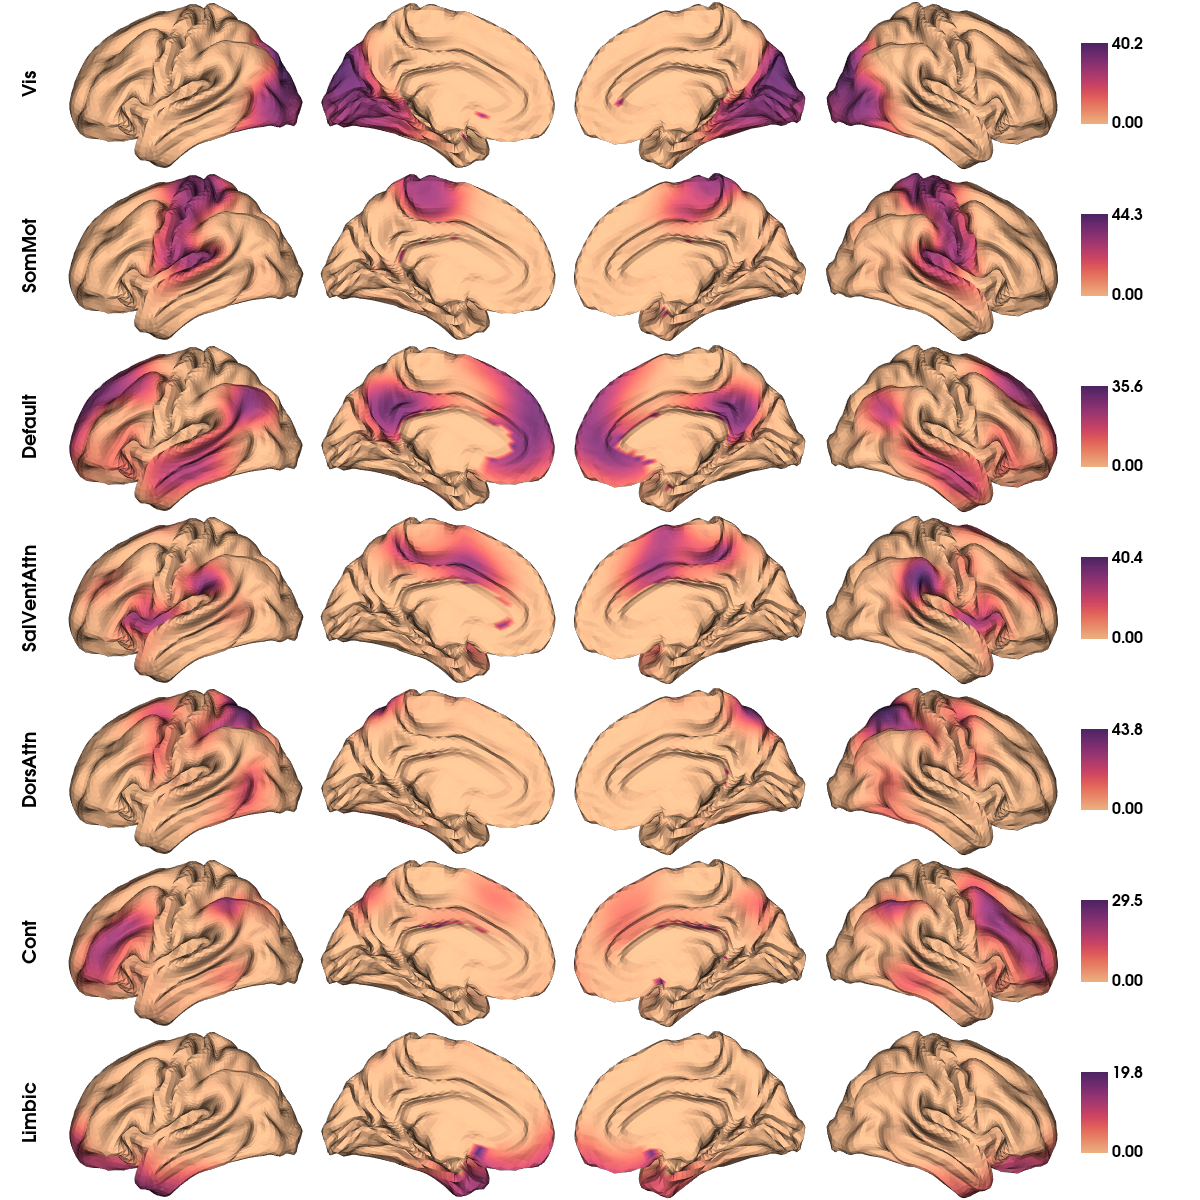

In [9]:
# Here we define the atlas
atlas='schaefer-400'

# Load annotations
lh_lab = nb.freesurfer.io.read_annot(micapipe + '/parcellations/lh.' + atlas + '_mics.annot')
rh_lab = nb.freesurfer.io.read_annot(micapipe + '/parcellations/rh.' + atlas + '_mics.annot')
labs = lh_lab[2][1:] + rh_lab[2][1:]

# Plot each YEO network
netStrs = ['Vis', 'SomMot', 'Default', 'SalVentAttn', 'DorsAttn', 'Cont', 'Limbic' ]
networks = [None] * len(netStrs)

# Positive correlations
fc_pos = np.copy(fc_ctx)
fc_pos[(0>fc_pos)] = 0

for i, netNom in enumerate(netStrs):
    print(str(i) + ' ' + netNom)
    #indx = [netNom in str(x) for x in labs]
    indx = [int(netNom in str(x)) for x in labs]  # Convert True/False to 1/0
    #net = np.sum(fc_pos[indx,:], axis=0)
    net = np.sum(fc_pos*indx, axis=0)
    #networks[i] = map_to_labels(net, labels_c69, fill=np.nan, mask=mask_32k)
    networks[i] = parcel_to_surface(net, 'schaefer-400_fsLR5k')
    networks[i] = smooth_surf(f5k_lh, f5k_rh, networks[i], mask_surf, Kernel='gaussian', Niter=20, Relax=0.8)
    del(net)
    
# YEO networks
plot_hemispheres(f5k_lh, f5k_rh, array_name=networks, size=(1200, 1200), cmap='flare',
                 embed_nb=True,  label_text={'left':netStrs}, color_bar='right',
                 zoom=1.75, nan_color=(0, 0, 0, 1), interactive=False, background=(0,0,0),
                screenshot=False)

In [22]:
SWM_mMPC = np.load('/host/percy/local_raid/youngeun/myjupyter/array/mMPC_5k_SWM_G1.npy')
SWM_T1map = np.load('/host/percy/local_raid/youngeun/myjupyter/array/T1map_SWM_G1.npy')
SWM_MTSAT = np.load('/host/percy/local_raid/youngeun/myjupyter/array/MTSAT_SWM_G1_new.npy')
SWM_FA = np.load('/host/percy/local_raid/youngeun/myjupyter/array/FA_SWM_G1.npy')
SWM_ODI = np.load('/host/percy/local_raid/youngeun/myjupyter/array/ODI_SWM_G1.npy')

GM_T1map = np.load('/host/percy/local_raid/youngeun/myjupyter/array/T1map_GM_G1.npy')

0 Vis
1 SomMot
2 Default
3 SalVentAttn
4 DorsAttn
5 Cont
6 Limbic


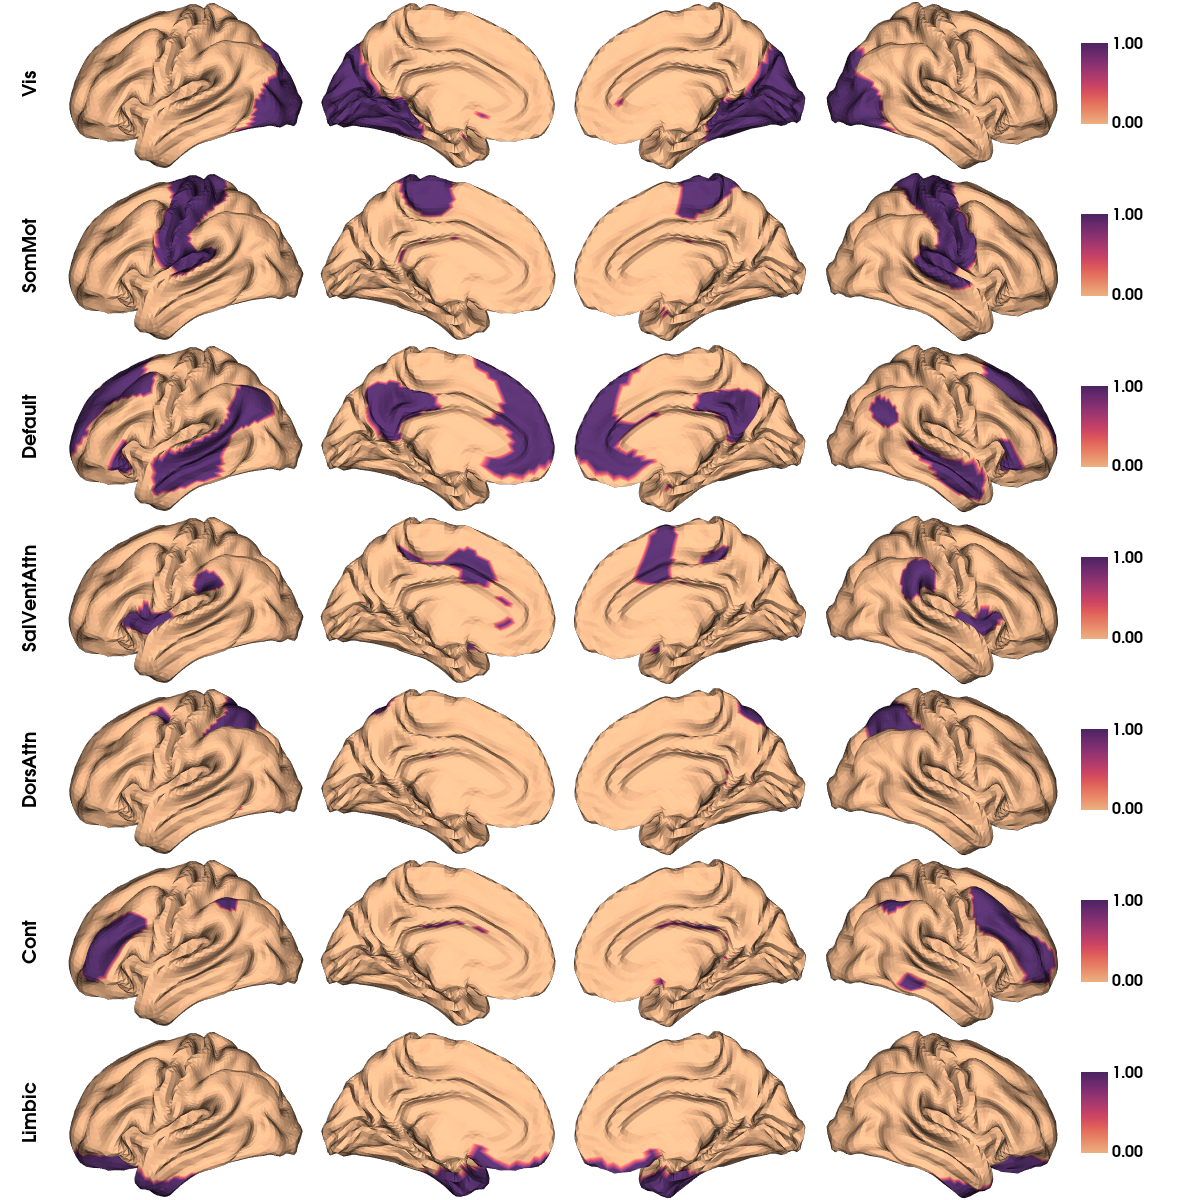

In [11]:
for i, netNom in enumerate(netStrs):
    print(str(i) + ' ' + netNom)
    indx = [int(netNom in str(x)) for x in labs]  # Convert True/False to 1/0
    arry = np.array(indx)
    networks[i] = parcel_to_surface(arry, 'schaefer-400_fsLR5k')
    networks[i] = smooth_surf(f5k_lh, f5k_rh, networks[i], mask_surf, Kernel='gaussian', Niter=20, Relax=0.8)
    networks[i] = np.round(networks[i])
    del(arry)

# YEO networks
plot_hemispheres(f5k_lh, f5k_rh, array_name=networks, size=(1200, 1200), cmap='flare',
                 embed_nb=True,  label_text={'left':netStrs}, color_bar='right',
                 zoom=1.75, nan_color=(0, 0, 0, 1), interactive=False, background=(0,0,0),
                screenshot=False)

In [12]:
SWM_mMPC = np.load('/host/percy/local_raid/youngeun/myjupyter/array/mMPC_5k_SWM_G1.npy')
SWM_T1map = np.load('/host/percy/local_raid/youngeun/myjupyter/array/T1map_SWM_G1.npy')
SWM_MTSAT = np.load('/host/percy/local_raid/youngeun/myjupyter/array/MTSAT_SWM_G1_new.npy')
SWM_FA = np.load('/host/percy/local_raid/youngeun/myjupyter/array/FA_SWM_G1.npy')
SWM_ODI = np.load('/host/percy/local_raid/youngeun/myjupyter/array/ODI_SWM_G1.npy')

In [13]:
networks

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([1., 1., 0., ..., 0., 0., 0.]),
 array([0., 0., 1., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 1., 1., 1.]),
 array([0., 0., 0., ..., 0., 0., 0.])]

In [14]:
values = []
for network in networks:
    extracted_values = SWM_T1map[network == 1]
    values.append(extracted_values)

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np; np.random.seed(2)
import random; random.seed(2)
import joypy

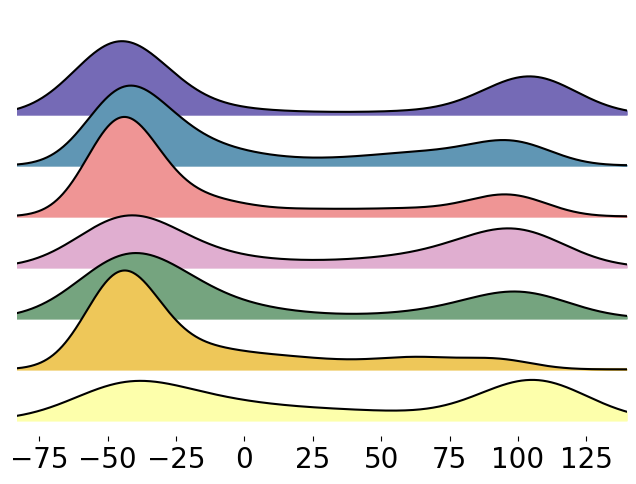

In [17]:
values = []
for network in networks:
    extracted_values = SWM_T1map[network == 1]
    values.append(extracted_values)

custom4G1 = [(117/255, 106/255, 182/255),  # Visual
             (96/255, 150/255, 180/255),  # Somatomotor
             (239/255, 149/255, 149/255),  # Default mode
             (224/255, 174/255, 208/255),   # Ventral Attention    
             (117/255, 164/255, 127/255),   # Dorsal Attention
             (238/255, 199/255, 89/255),   # Frontoparietal         
             (253/255, 255/255, 171/255)]  # Limbic 

#custom4G1 = [(239/255, 149/255, 149/255),  # Default mode
#             (238/255, 199/255, 89/255),   # Frontoparietal     
#             (117/255, 106/255, 182/255),  # Visual
#             (96/255, 150/255, 180/255),  # Somatomotor
#             (117/255, 164/255, 127/255),   # Dorsal Attention
#             (203/255, 170/255, 203/255),   # Ventral Attention   
#             (253/255, 255/255, 171/255)]  # Limbic 
    
# Sample data
df = [values[0], values[1], values[2], values[3], values[4], values[5], values[6]]
#df = [values[2], values[5], values[0], values[1], values[4], values[3], values[6]]

fig, ax = joypy.joyplot(df, color = custom4G1)

plt.xticks(fontsize=20)
plt.show()

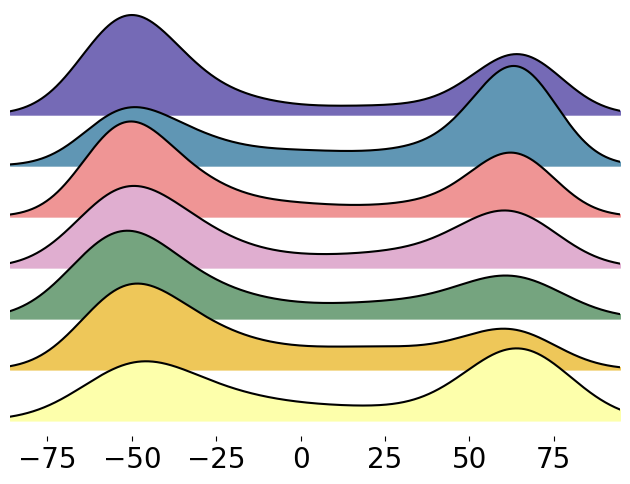

In [18]:
custom4G1 = [(117/255, 106/255, 182/255),  # Visual
             (96/255, 150/255, 180/255),  # Somatomotor
             (239/255, 149/255, 149/255),  # Default mode
             (224/255, 174/255, 208/255),   # Ventral Attention    
             (117/255, 164/255, 127/255),   # Dorsal Attention
             (238/255, 199/255, 89/255),   # Frontoparietal         
             (253/255, 255/255, 171/255)]  # Limbic 

values = []
for network in networks:
    extracted_values = SWM_MTSAT[network == 1]
    values.append(extracted_values)

# Sample data
df = [values[0], values[1], values[2], values[3], values[4], values[5], values[6]]

fig, ax = joypy.joyplot(df, color = custom4G1)

plt.xticks(fontsize=20)
plt.show()

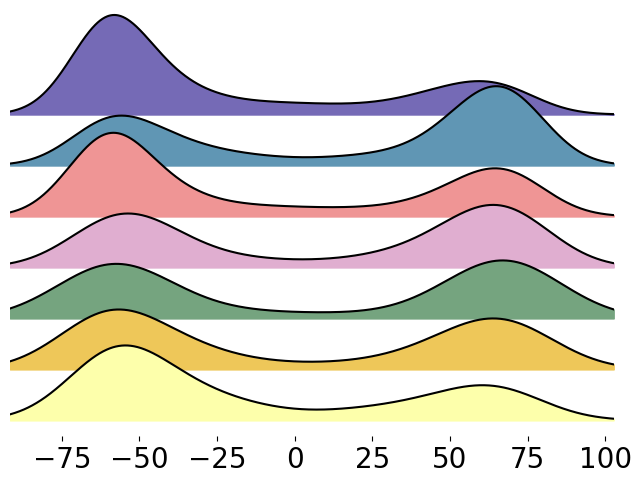

In [19]:
custom4G1 = [(117/255, 106/255, 182/255),  # Visual
             (96/255, 150/255, 180/255),  # Somatomotor
             (239/255, 149/255, 149/255),  # Default mode
             (224/255, 174/255, 208/255),   # Ventral Attention    
             (117/255, 164/255, 127/255),   # Dorsal Attention
             (238/255, 199/255, 89/255),   # Frontoparietal         
             (253/255, 255/255, 171/255)]  # Limbic 

values = []
for network in networks:
    extracted_values = SWM_FA[network == 1]
    values.append(extracted_values)

# Sample data
df = [values[0], values[1], values[2], values[3], values[4], values[5], values[6]]

fig, ax = joypy.joyplot(df, color = custom4G1)

plt.xticks(fontsize=20)
plt.show()

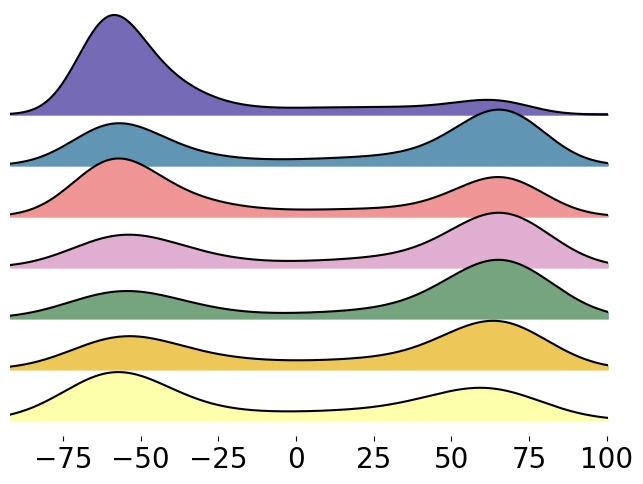

In [23]:
custom4G1 = [(117/255, 106/255, 182/255),  # Visual
             (96/255, 150/255, 180/255),  # Somatomotor
             (239/255, 149/255, 149/255),  # Default mode
             (224/255, 174/255, 208/255),   # Ventral Attention    
             (117/255, 164/255, 127/255),   # Dorsal Attention
             (238/255, 199/255, 89/255),   # Frontoparietal         
             (253/255, 255/255, 171/255)]  # Limbic 

values = []
for network in networks:
    extracted_values = SWM_ODI[network == 1]
    values.append(extracted_values)

# Sample data
df = [values[0], values[1], values[2], values[3], values[4], values[5], values[6]]

fig, ax = joypy.joyplot(df, color = custom4G1)

plt.xticks(fontsize=20)
plt.show()

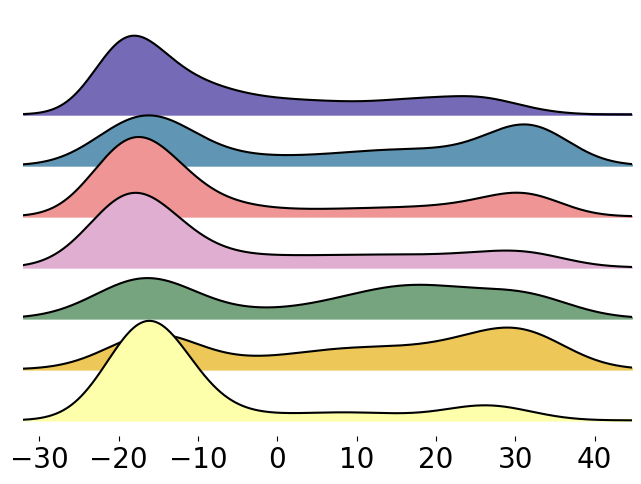

In [21]:
custom4G1 = [(117/255, 106/255, 182/255),  # Visual
             (96/255, 150/255, 180/255),  # Somatomotor
             (239/255, 149/255, 149/255),  # Default mode
             (224/255, 174/255, 208/255),   # Ventral Attention    
             (117/255, 164/255, 127/255),   # Dorsal Attention
             (238/255, 199/255, 89/255),   # Frontoparietal         
             (253/255, 255/255, 171/255)]  # Limbic 

values = []
for network in networks:
    extracted_values = SWM_mMPC[network == 1]
    values.append(extracted_values)

# Sample data
df = [values[0], values[1], values[2], values[3], values[4], values[5], values[6]]

fig, ax = joypy.joyplot(df, color = custom4G1)

plt.xticks(fontsize=20)
plt.show()